Distribuzione delle classi:
 label
2    0.528183
4    0.172251
3    0.135199
5    0.069373
6    0.056366
7    0.038628
Name: proportion, dtype: float64

Training SVM pipeline


/home/achille/Desktop/ML/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [   1   10   22   25   37   41   50   52   56   57   58   61   64   65
   70   81   84   86   89   93   97  103  122  123  129  130  135  138
  142  143  150  151  155  156  161  166  171  176  177  181  183  186
  187  189  207  210  218  219  223  240  254  266  273  284  291  292
  293  298  301  304  305  309  317  325  338  344  346  349  350  352
  359  362  365  366  369  373  375  382  385  403  405  414  419  420
  422  437  442  443  452  454  456  459  461  462  466  468  490  494
  496  513  515  535  544  551  561  590  599  600  601  604  606  610
  614  622  636  637  641  642  643  648  650  652  653  661  663  665
  668  679  680  681  682  690  695  699  701  727  728  731  733  734
  735  739  742  743  746  755  764  767  772  779  786  790  812  815
  819  823  826  832  836  839  841  852  855  857  874  889  891  894
  902  904

Best parameters for SVM: {'selector__score_func': <function mutual_info_classif at 0x77f623b53370>, 'selector__k': 'all', 'classifier__kernel': 'rbf', 'classifier__C': 100}
Best score for SVM: 0.3706

Valutazione SVM sul test set:

--- Evaluation: SVM ---
Classification Report:
              precision    recall  f1-score   support

           2       0.68      0.77      0.72       268
           3       0.57      0.57      0.57        69
           4       0.28      0.26      0.27        87
           5       0.19      0.11      0.14        35
           6       0.28      0.17      0.21        29
           7       0.77      0.50      0.61        20

    accuracy                           0.57       508
   macro avg       0.46      0.40      0.42       508
weighted avg       0.54      0.57      0.55       508

Confusion Matrix:
[[207  14  31  10   5   1]
 [ 19  39  10   0   0   1]
 [ 48   5  23   6   5   0]
 [ 14   2  11   4   3   1]
 [ 11   4   8   1   5   0]
 [  5   5   0   0   0  10

/tmp/ipykernel_42234/1198254196.py:277: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Macro', y='Model', data=results_df.sort_values('F1 Macro', ascending=False), palette='viridis')


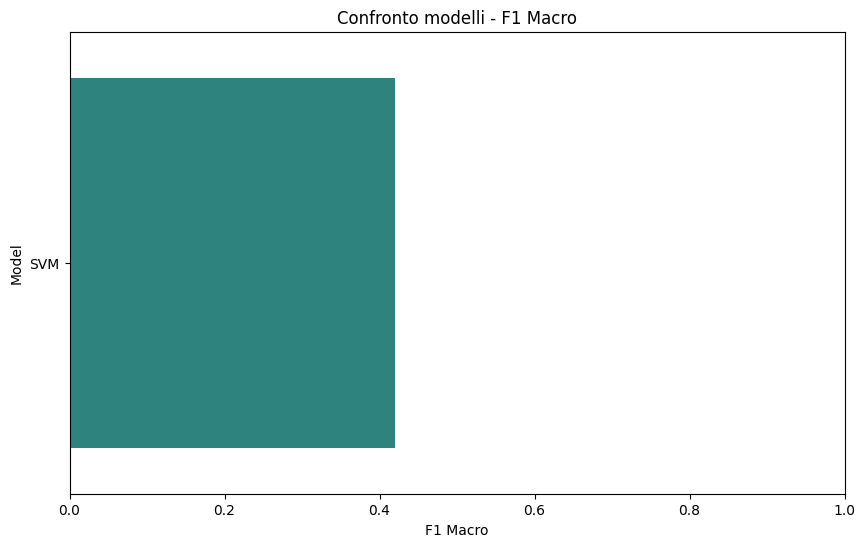

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, SVMSMOTE
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import logging
import datetime
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif


# Configurazione logging datetime
logging.basicConfig(
    filename=f"logs/model_evaluation_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.log",
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Funzione per valutazione del modello
def evaluate_model(model, X_test, y_test, model_name=""):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    log_msg = (
        f"\n--- Evaluation: {model_name} ---\n"
        f"Classification Report:\n{report}\n"
        f"Confusion Matrix:\n{matrix}\n"
        f"Balanced Accuracy: {bal_acc}\n"
        f"F1 Macro: {f1}\n"
        + "-"*80
    )
    
    logging.info(log_msg)
    print(log_msg)

# Pipeline 1: XGBoost 
def create_xgb_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=0.0)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=20)), 
        ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
    ])
    
    param_dist = {
        'selector__k': [10, 20, 30, 'all'],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
    
    return pipeline, param_dist

# Pipeline 2: Random Forest
def create_rf_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=0.0)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=20)), 
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ])
    
    param_dist = {
        'selector__k': [10, 20, 30, 'all'],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
    
    return pipeline, param_dist

# Pipeline 3: SVM 
def create_svm_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=1e-5)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()), 
        ('classifier', SVC(random_state=42, class_weight='balanced'))
    ])

    param_dist = {
        'selector__k': [10, 20, 30, 'all'],
        'selector__score_func': [f_classif, mutual_info_classif],
        'classifier__C': [0.01, 0.1, 1, 10, 100, 1000],
        'classifier__kernel': ['linear', 'rbf']  # rimuovi 'poly' per velocità se vuoi
    }

    return pipeline, param_dist


# Pipeline 4: Logistic Regression 
def create_lr_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=0.0)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=20)), 
        ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
    ])
    
    param_dist = {
        'selector__k': [10, 20, 30, 'all'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }
    
    return pipeline, param_dist

# Pipeline 5: KNN
def create_knn_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=0.0)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=20)),
        ('classifier', KNeighborsClassifier())
    ])
    
    param_dist = {
        'selector__k': [10, 20, 30, 'all'],
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]  # 1: manhattan, 2: euclidean
    }
    
    return pipeline, param_dist


# Pipeline 6: VotingClassifier
def create_light_gmb_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=0.0)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=20)),
        ('classifier', lgb.LGBMClassifier(random_state=42))
    ])
    
    param_dist = {
        'selector__k': [10, 20, 30, 'all'],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
    
    return pipeline, param_dist

def main():
    # Caricamento dati
    # take the csv int the previous directory
    df = pd.read_csv("../roi_features_train.csv")
    X = df.drop(columns=["image_id", "score", "x1", "y1", "x2", "y2", "label"])
    y = df["label"]

    # togli classe 1
    X = X[y != 1]
    y = y[y != 1]

    
    
    

    # Reset index after filtering
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)


    # Analisi distribuzione classi
    print("Distribuzione delle classi:\n", y.value_counts(normalize=True))

    # Select k best for visualization
    selector = SelectKBest(score_func=f_classif, k=20)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]

    
    # # scatter plot 
    # plt.figure(figsize=(10, 6))
    # sns.scatterplot(x=X_selected[:, 0], y=X_selected[:, 1], hue
    #             =y, palette='viridis', alpha=0.7)
    # plt.title("Scatter plot delle prime due feature selezionate")
    # plt.xlabel(selected_features[0])
    # plt.ylabel(selected_features[1])
    # plt.legend(title='Classi', loc='upper right')
    # plt.show()

    # # pair plot delle prime due feature selezionate
    # df_pairplot = pd.DataFrame(X_selected, columns=selected_features)
    # df_pairplot['label'] = y



    # sns.pairplot(df_pairplot, hue='label', diag_kind='kde', palette='viridis')
    # plt.suptitle("Pair plot delle prime due feature selezionate", y=1.02)
    # plt.show()

    
    

    
    # Train-test split stratificato (senza feature selection per permettere a ogni pipeline di gestirla)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Lista di tutte le pipeline da sperimentare
    pipelines = [
        #("XGBoost", create_xgb_pipeline()),
        #("Random Forest", create_rf_pipeline()),
        ("SVM", create_svm_pipeline()),
        #("Logistic Regression", create_lr_pipeline()),
        #("KNN", create_knn_pipeline())
    ]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = []

    for name, (pipeline, param_dist) in pipelines:
        print(f"\n{'='*40}")
        print(f"Training {name} pipeline")
        print(f"{'='*40}")
        
        search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=cv,
                                scoring='f1_macro', n_iter=10, random_state=42, n_jobs=-1)
        
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        #log the best parameters
        logging.info(f"Best parameters for {name}: {search.best_params_}")
        print(f"Best parameters for {name}: {search.best_params_}")
        print(f"Best score for {name}: {search.best_score_:.4f}")
        logging.info(f"Best score for {name}: {search.best_score_:.4f}")
        
        
        y_pred = best_model.predict(X_test)
        
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        results.append({
            "Model": name,
            "Best Params": search.best_params_,
            "Balanced Accuracy": bal_acc,
            "F1 Macro": f1
        })
        
        print(f"\nValutazione {name} sul test set:")
        evaluate_model(best_model, X_test, y_test, model_name=name)

    # Output tabellare finale
    results_df = pd.DataFrame(results)
    print("\nConfronto Finale:")
    print(results_df.sort_values(by="F1 Macro", ascending=False))
    logging.info("\nConfronto Finale:\n" + str(results_df.sort_values(by="F1 Macro", ascending=False)))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='F1 Macro', y='Model', data=results_df.sort_values('F1 Macro', ascending=False), palette='viridis')
    plt.title("Confronto modelli - F1 Macro")
    plt.xlim(0, 1)



if __name__ == "__main__":
    main()